## Hopfield Networks

[Neural networks and physical systems with emergent collective computationalabilities](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC346238/pdf/pnas00447-0135.pdf) (1982)

In [314]:
import numpy as np
import matplotlib.pyplot as plt

In [315]:
# np.random.seed(123)

In [316]:
class hopfield():
    def __init__(self, ndim):
        self.ndim = ndim
        self.weights = np.zeros((self.ndim, self.ndim))

    def train(self, data, threshold=0.1):
        for sample in data:
            memory = np.array([np.where(sample > threshold, 1, -1)]) # Binary dipole (+/-)
            delta_weights = memory.T * memory
            self.weights += delta_weights
            self.weights = (self.weights + self.weights.T) / 2 # Enforce symmetrical weights
        self.weights /= data.shape[0] # Normalise against dataset
        np.fill_diagonal(self.weights, 0) # Set the diagonal to zero - ensure nodes to influence themselves

    def infer(self, state, units, T):
        for _ in range(units):
            rand_idx = np.random.randint(1, self.ndim)
            spin = np.dot(self.weights[rand_idx,:], state) # Activation function

            # state[rand_idx] = self.step(spin)

            prob = self.sigmoid(spin / T)
            state[rand_idx] = self.bernoulli(prob)

        return state

    def step(self, y): # Step / Threshold activation function
        return 1 if y > 0 else -1

    def sigmoid(self, x): # Continuous activation function
        return 1.0 / (1.0 + np.exp(-x))

    def bernoulli(self, prob): # Bernoulli distribution
        return 1 if np.random.uniform(0, 1) < prob else -1

    def compute_energy(self, state): # As per original paper
        return -0.5 * np.dot(np.dot(self.weights, state), state.T)

In [317]:
ndim = 64
memory = 8

In [318]:
data = np.array([1 if x > 0.5 else -1 for x in np.random.rand(ndim * memory)], dtype=np.int8)
data = data.reshape(memory, ndim)

print(data[0])
print(data.shape)

[ 1 -1 -1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1  1  1 -1 -1 -1
 -1 -1  1  1 -1  1 -1  1  1  1  1 -1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1
  1 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1]
(8, 64)


In [319]:
# Build model
model = hopfield(ndim)

In [320]:
# Summary
w = int((ndim * (ndim - 1)) / 2)

print(ndim, "neurons")
print(w, "weighted connections")
print(f"{ndim * 0.138:.2f} point attactors")
print(f"{0.24 * w:.2f} bit capacity")

64 neurons
2016 weighted connections
8.83 point attactors
483.84 bit capacity


In [321]:
# Train (Encoding)
model.train(data)

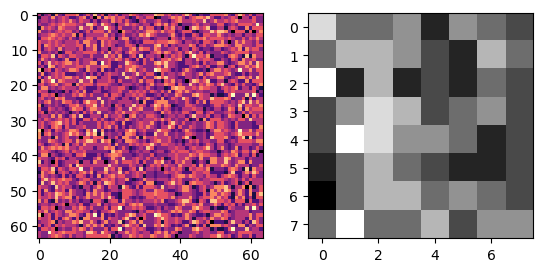

In [322]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(model.weights, cmap='magma')

plt.subplot(1,2,2)
plt.imshow(model.weights[1].reshape(int(ndim**0.5),int(ndim**0.5)), cmap='binary')

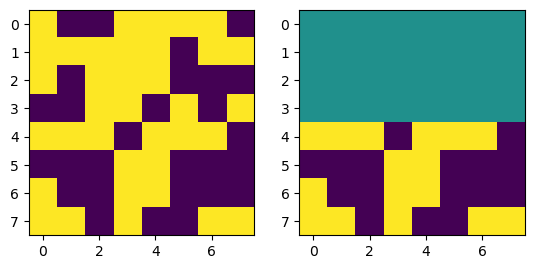

In [323]:
# state = np.random.randint(-1,2,(model.ndim)) # Noise

plt.subplot(1,2,1)
state = data[0]
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

plt.subplot(1,2,2)
state[:32] = 0
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

/var/folders/lq/rt5hds253qx39fzyvzdrmcfh0000gn/T/ipykernel_19979/110609330.py:31: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


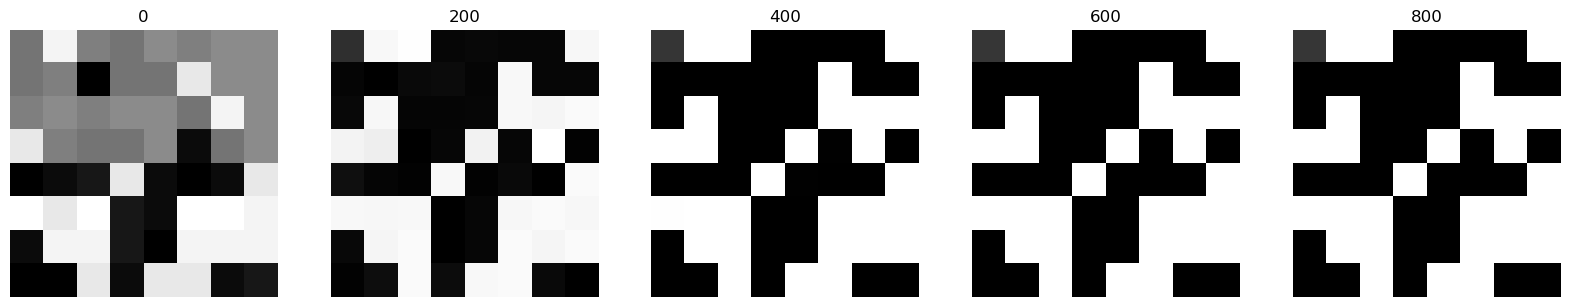

In [324]:
# Infer (Retrieval)
steps = 1000
n_update = 16
energy = []
T = 1.0

plt.figure(figsize=(20,200))
for i in range(steps):
    state = model.infer(state, n_update, T).astype(float)
    E = model.compute_energy(state)
    energy.append(E)

    noise = np.random.randint(-1,2, state.shape) * T * 0.1 # Add disturbance
    state += noise

    T = max(T * 0.99, 0.001) # Simulated annealing

    stamp = steps / 5
    if i%stamp == 0:
        m = int((i/stamp)+1)
        plt.subplot(1, int(steps/stamp), m)
        plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)), cmap='binary')
        plt.title(i)
        plt.axis('off')

(Text(0.5, 0, 'Time'), Text(0, 0.5, 'Energy'))

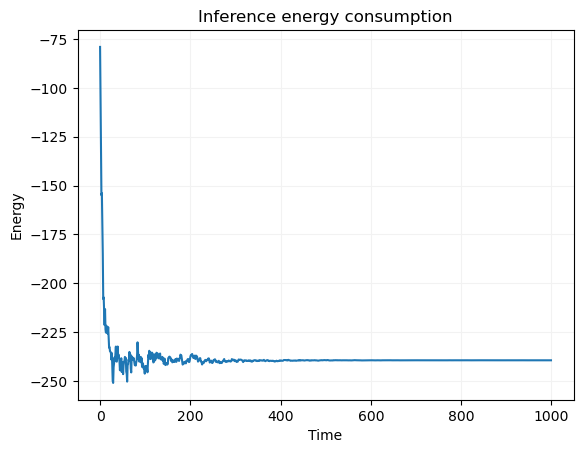

In [325]:
x = np.arange(len(energy))
y = np.array(energy).squeeze()

plt.figure()
plt.plot(x, y)
plt.grid(axis='both', color='0.95')
plt.title('Inference energy consumption')
plt.xlabel('Time'), plt.ylabel('Energy')